In [1]:
import os
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import PIL
from PIL import Image
import sklearn
from sklearn import preprocessing
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
print(tf.__version__)
#limit GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0],True)

2.0.0


In [2]:
val_dir = "./dogs-cats-images/dataset/test_set/"
train_dir = "./dogs-cats-images/dataset/training_set/"
print(os.path.exists(val_dir))
print(os.path.exists(train_dir))

True
True


In [3]:
#config input images
height = 128
width = 128
channels = 3
batch_size = 16
num_class = 2
class_name = ['cat','dog']

In [4]:

#callbacks
logdir = './callbacks'
if not os.path.exists:
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,'cat_dog_model.h5')

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=10,min_delta=1e-3),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=5,verbose=1,factor=0.5,min_lr=0.00001)  
]

In [5]:
train_data_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,#增加位移鲁棒性
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',    
)

val_data_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  
)

In [6]:
train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(height,width),
    batch_size=batch_size,
    seed=1,
    shuffle=True,
    class_mode='categorical'
)

val_generator = val_data_gen.flow_from_directory(
    val_dir,
    target_size=(height,width),
    batch_size=batch_size,
    seed=1,
    shuffle=True,
    class_mode='categorical'
)


train_num = train_generator.samples
val_num = val_generator.samples

Found 8000 images belonging to 2 classes.
Found 1954 images belonging to 2 classes.


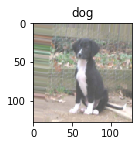

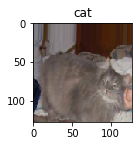

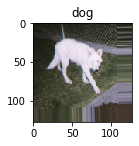

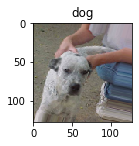

In [7]:
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    for x_batch,y_batch in train_generator:
        image = x_batch[0]
        plt.imshow(image)
        plt.title(class_name[y_batch.astype(np.int8)[0][1]])
        break
        
    plt.show()

In [8]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,
                       activation='relu',input_shape=[width,height,channels]),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(filters=64,kernel_size=3,
                       activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(filters=128,kernel_size=3,
                       activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(num_class,activation='softmax'),
])

In [9]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [10]:
epochs = 50
history = model.fit_generator(train_generator,
                             epochs=epochs,
                             validation_data=val_generator,
                             validation_steps=val_num//batch_size,
                             steps_per_epoch=train_num//batch_size,
                             callbacks=callbacks)

Epoch 1/50
500/500 [==============================] - 51s 102ms/step - loss: 0.8209 - accuracy: 0.5821 - val_loss: 0.7106 - val_accuracy: 0.5799
Epoch 2/50
500/500 [==============================] - 42s 85ms/step - loss: 0.6747 - accuracy: 0.6111 - val_loss: 0.6338 - val_accuracy: 0.6496
Epoch 3/50
500/500 [==============================] - 41s 83ms/step - loss: 0.6443 - accuracy: 0.6369 - val_loss: 0.7099 - val_accuracy: 0.6276
Epoch 4/50
500/500 [==============================] - 41s 82ms/step - loss: 0.6329 - accuracy: 0.6442 - val_loss: 0.6514 - val_accuracy: 0.6516
Epoch 5/50
500/500 [==============================] - 42s 83ms/step - loss: 0.6211 - accuracy: 0.6580 - val_loss: 0.5330 - val_accuracy: 0.7295
Epoch 6/50
500/500 [==============================] - 41s 82ms/step - loss: 0.5952 - accuracy: 0.6845 - val_loss: 0.6602 - val_accuracy: 0.6588
Epoch 7/50
500/500 [==============================] - 41s 82ms/step - loss: 0.5772 - accuracy: 0.6982 - val_loss: 0.6002 - val_accuracy

In [11]:
model.load_weights("cat_dog.h5")

In [27]:
model.save_weights('cat_dog.h5')


In [12]:
def plot_learning_curve(history,label):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8,5))
    plt.show()

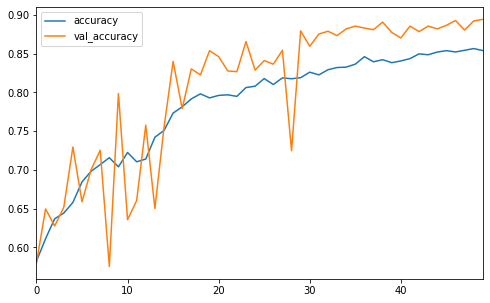

In [13]:
plot_learning_curve(history,'accuracy')

In [20]:
#Test data
test_dir =  "./dogs-cats-images/dataset/mix/"
test_filename = os.listdir(test_dir)
print(os.path.exists(test_dir))

True


In [21]:
#test_generator
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input)

In [24]:
test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=(width,height),
    batch_size=batch_size,
)
nb_sample = test_generator.samples
nb_sample

Found 198 images belonging to 2 classes.


198

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


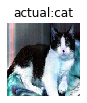

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


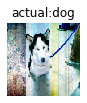

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


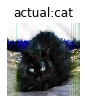

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


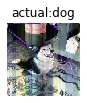

In [30]:
plt.figure()
for i in range(4):
    plt.subplot(1,4,i+1)
    for x_batch,y_batch in test_generator:
        image = x_batch[0]
        print(image.shape)
#         pred = model.predict(image.reshape((-1,224,224,3)))
#         print('Predict:%s'%class_name[pred.argmax(axis=1).astype(np.int8)[0]])
        M_scaler = preprocessing.MinMaxScaler()
        for i in range(3):
            image[:,:,i] = M_scaler.fit_transform(image[:,:,i])
        plt.imshow(image)
        plt.title('actual:%s'%class_name[y_batch.astype(np.int8)[0][1]])
        plt.axis('off')
        break        
    plt.show()